# Demo: Seismic Regularization

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pylops

from scipy.signal import convolve
from pylops.optimization.sparsity import fista
from curvelops import FDCT2D

np.random.seed(0)
warnings.filterwarnings("ignore")


In [2]:
inputfile = "../testdata/seismic.npz"
inputdata = np.load(inputfile)

x = inputdata["R"][50, :, ::2]
x = x / np.abs(x).max()
taxis, xaxis = inputdata["t"][::2], inputdata["r"][0]

par = {}
par["nx"], par["nt"] = x.shape
par["dx"] = inputdata["r"][0, 1] - inputdata["r"][0, 0]
par["dt"] = inputdata["t"][1] - inputdata["t"][0]

# add wavelet
wav = inputdata["wav"][::2]
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode="full")
x = x[:, wav_c:][:, : par["nt"]]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par["nx"])).T
x *= gain

# subsampling locations
perc_subsampling = 0.5
Nsub = int(np.round(par["nx"] * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par["nx"]))[:Nsub])

# restriction operator
Rop = pylops.Restriction((par["nx"], par["nt"]), iava, axis=0, dtype="float64")

y = Rop @ x
xadj = Rop.H @ y

# apply mask
ymask = Rop.mask(x)

### Curvelet transform

(0.0, 3000.0, 1.995, 0.0)

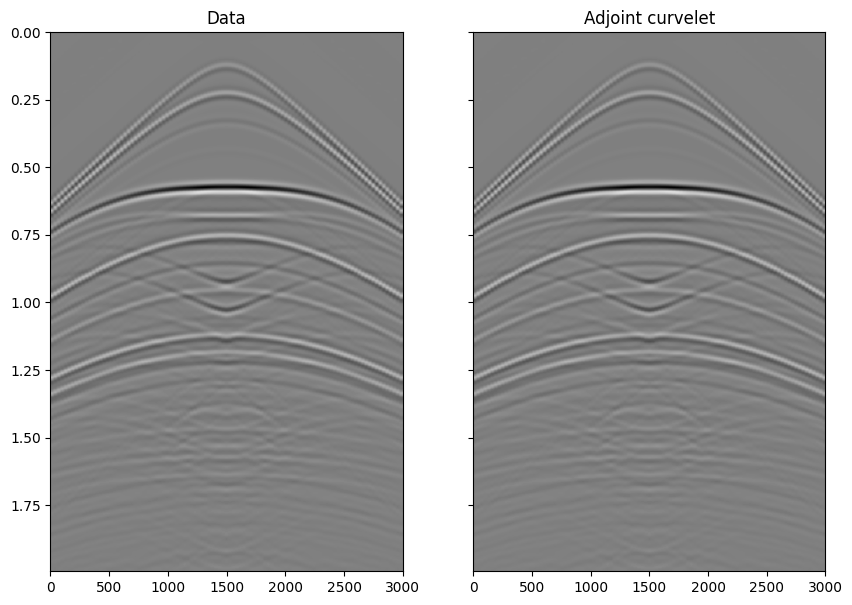

In [3]:
DCTOp = FDCT2D((par["nx"], par["nt"]), nbscales=4)

yc = DCTOp @ x
xcadj = DCTOp.H @ yc

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
axs[0].imshow(
    x.T,
    cmap="gray",
    vmin=-0.1,
    vmax=0.1,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[0].set_title("Data")
axs[0].axis("tight")
axs[1].imshow(
    np.real(xcadj).T,
    cmap="gray",
    vmin=-0.1,
    vmax=0.1,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[1].set_title("Adjoint curvelet")
axs[1].axis("tight")

### Reconstruction based on Curvelet transform

In [4]:
# combined modelling operator
RCop = Rop @ DCTOp.H
RCop.dims = (RCop.shape[1],)  # flatten
RCop.dimsd = (RCop.shape[0],)

# inverse
pl1, _, cost = fista(RCop, y.ravel(), niter=100, eps=1e-3, show=True)

xl1 = (DCTOp.H @ pl1).real.reshape(x.shape)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 20000 rows and 305683 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	thresh = 5.000000e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -7.50e-04+7.58e-19j    1.067e-02   2.690e-01   1.383e+00
     2   -9.12e-04+5.16e-19j    9.923e-03   2.541e-01   8.676e-02
     3   -1.04e-03+1.27e-19j    9.270e-03   2.408e-01   9.289e-02
     4   -1.17e-03-1.43e-19j    8.703e-03   2.293e-01   9.611e-02
     5   -1.24e-03-1.52e-19j    8.240e-03   2.191e-01   9.767e-02
     6   -1.25e-03-1.53e-19j    7.846e-03   2.104e-01   9.769e-02
     7   -1.24e-03-1.52e-19j    7.534e-03   2.028e-01   9.678e-02
     8   -1.23e-03-1.50e-19j    7.286e-03   1.963e-01   9.516e-02
     9   -1.21e-03-1.49e-19j    7.091e-03   1.906e-01   9.344e-02
    10   -1.2

Text(0.5, 1.0, 'FISTA convergence')

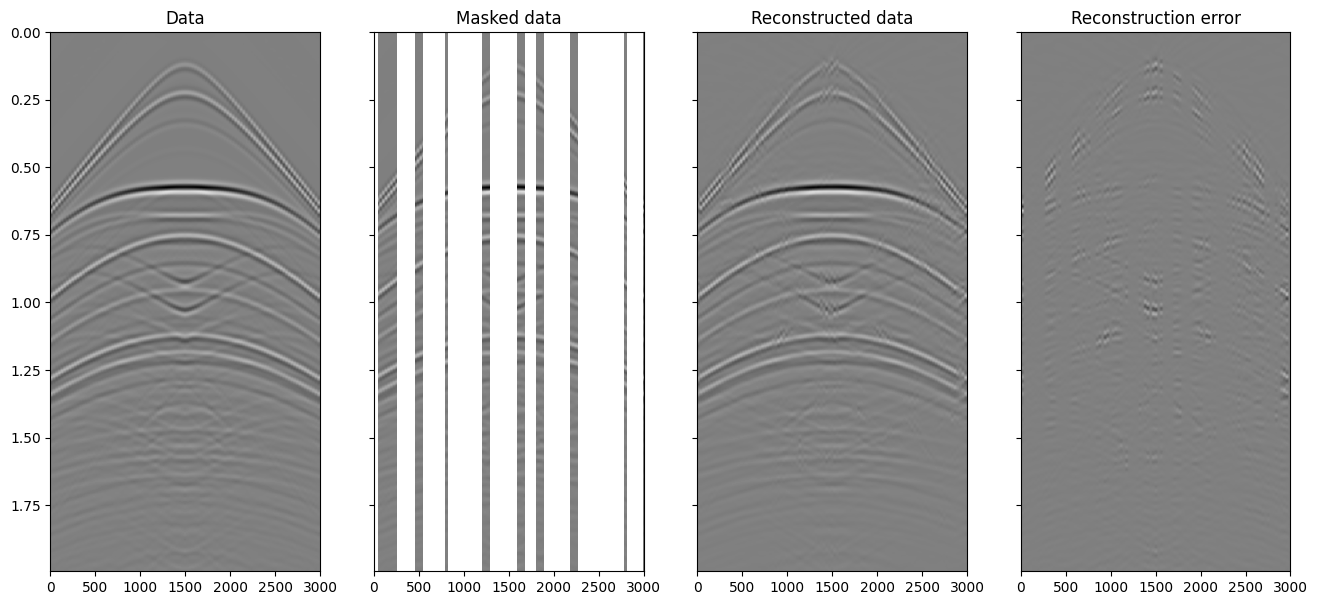

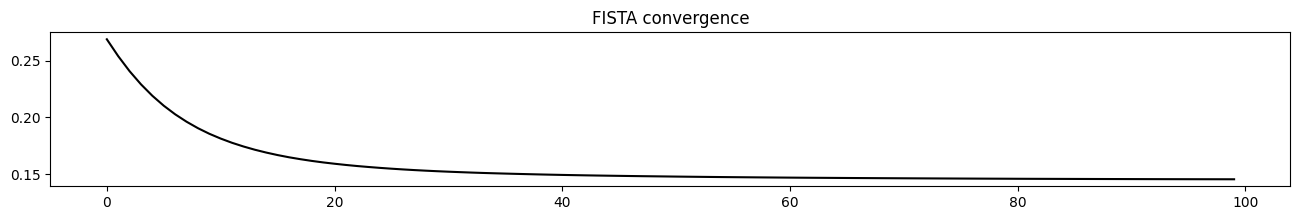

In [5]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 7))
axs[0].imshow(
    x.T,
    cmap="gray",
    vmin=-0.1,
    vmax=0.1,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[0].set_title("Data")
axs[0].axis("tight")
axs[1].imshow(
    ymask.T,
    cmap="gray",
    vmin=-0.1,
    vmax=0.1,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[1].set_title("Masked data")
axs[1].axis("tight")
axs[2].imshow(
    xl1.T,
    cmap="gray",
    vmin=-0.1,
    vmax=0.1,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[2].set_title("Reconstructed data")
axs[2].axis("tight")
axs[3].imshow(
    (x - xl1).T,
    cmap="gray",
    vmin=-0.1,
    vmax=0.1,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[3].set_title("Reconstruction error")
axs[3].axis("tight")

plt.figure(figsize=(16, 2))
plt.plot(cost, "k")
plt.title("FISTA convergence")